In [2]:
#Imports
import torch
import torch.nn.functional as F

import tensorly as tl
from tensorly import decomposition
from tensorly import random
from tensorly.decomposition import parafac

import numpy as np
from scipy.stats import ortho_group
from scipy import linalg
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from PIL import Image

from scipy.linalg import dft

import timeit

In [3]:
### Khatri-Rao Random Projection
A_1 = np.random.normal(0.0,1.0,(10,900))
A_2 = np.random.normal(0.0,1.0,(10,900))
A_3 = np.random.normal(0.0,1.0,(10,900))
A_4 = linalg.khatri_rao(A_1,linalg.khatri_rao(A_2,A_3))

In [4]:
### Embedding of Random Vectors
y = np.random.normal(0,1,1000)
y = y/np.linalg.norm(y)
np.linalg.norm(A_4.T@y)*(1/np.sqrt(900))

0.9719847016719102

In [5]:
#### Generate Random Mode-3 low CP rank Tensors #######

def random_low_cp_rank(n,r):   #### CP Rank r
    #torch.manual_seed(0)
    #np.random.seed(0)
    
    L = []
    for i in range(0,len(n)):
        C = np.random.normal(0,1,size=(n[i],r))
        L = L + [C]
    
    X = np.zeros(n)
    for i in range(r):
        U_r = np.array(L[0])[:,i]
        for j in range(1, len(n)):
            prod = np.array(L[j])[:,i]
            U_r = np.multiply.outer(U_r,prod)
        X = X + U_r
        
    C=tl.tensor(X) #Changing data frame to tensor
    C.shape
    return C

In [6]:
n = (20,20,20) ### Mode 3 rank 2 tensors
dim = 6500

X = random_low_cp_rank(n,2)
X_ravel = np.ravel(X)
X_ravel = X_ravel/np.linalg.norm(X_ravel)

## Generating Khatri-Rao Random Projection Matrix

A_1 = np.random.normal(0.0,1.0,(n[0],dim))
A_2 = np.random.normal(0.0,1.0,(n[1],dim))
A_3 = np.random.normal(0.0,1.0,(n[2],dim))
A_4 = linalg.khatri_rao(A_1,linalg.khatri_rao(A_2,A_3))

AA = A_4.T*(1/np.sqrt(dim))

freedom = dim*np.sum(n)

In [7]:
## Checking if this is a reasonable Random Projection
np.abs(np.linalg.norm(AA@X_ravel)-1)

0.03495614483408904

In [8]:
## TIHT Preliminaries

def low_rank_approx(tensor,r):    
    #torch.manual_seed(0)
    factors = parafac(tl.tensor(tensor), rank=r)
    answer = tl.cp_to_tensor(factors)
    return answer

def vectorize_1(X): ##Vectorisation for tensors
    x=X.numpy()
    x=x.reshape(-1)
    return x

def vectorize(X):  ##Vecorisation for numpy arrays
    x=X
    x=x.reshape(-1)
    return x

In [317]:
#Initialisation of TIHT

vXX = torch.randn(n)
print(np.linalg.norm(vectorize(vXX)- X_ravel))
yy = np.matmul(AA, np.array(vectorize(X_ravel)))
Diff = np.linalg.norm(vectorize(vXX)- X_ravel)/np.linalg.norm(X_ravel)
print(Diff)

89.29776698874161
89.29776698874161


In [318]:
## Understanding the importance of momenetum or step size???

j = 0
num_its = 1000

while j < num_its and Diff > 0.001:
    WW = np.array(vectorize(vXX)) + 0.3 * np.matmul(AA.T, (yy - np.matmul(AA, np.array(vectorize(vXX)))))
    WW = torch.reshape(torch.tensor(WW), n)
    vXX = low_rank_approx(WW,2)
    Diff = np.linalg.norm(vectorize(vXX)- X_ravel)
    #print(Diff)
    j = j + 1
    
print("Converges in:", j, " iterations with error: ", Diff )

Converges in: 47  iterations with error:  0.0009124096520409628


In [379]:
### Considering Higher Rank Case ###

n = (20,20,20) ### Mode 3 rank 2 tensors
dim = 6000

X = random_low_cp_rank(n,3)
X_ravel = np.ravel(X)
X_ravel = X_ravel/np.linalg.norm(X_ravel)

## Generating Khatri-Rao Random Projection Matrix

A_1 = np.random.normal(0.0,1.0,(n[0],dim))
A_2 = np.random.normal(0.0,1.0,(n[1],dim))
A_3 = np.random.normal(0.0,1.0,(n[2],dim))
A_4 = linalg.khatri_rao(A_1,linalg.khatri_rao(A_2,A_3))

AA = A_4.T*(1/np.sqrt(dim))

freedom = dim*np.sum(n)


In [380]:
vXX = torch.randn(n)
print(np.linalg.norm(vectorize(vXX)- X_ravel))
yy = np.matmul(AA, np.array(vectorize(X_ravel)))
Diff = np.linalg.norm(vectorize(vXX)- X_ravel)/np.linalg.norm(X_ravel)
print(Diff)

90.30665122592872
90.30665122592872


In [381]:
j = 0
num_its = 1000

while j < num_its and Diff > 0.001:
    WW = np.array(vectorize(vXX)) + 0.3 * np.matmul(AA.T, (yy - np.matmul(AA, np.array(vectorize(vXX)))))
    WW = torch.reshape(torch.tensor(WW), n)
    vXX = low_rank_approx(WW,3)
    Diff = np.linalg.norm(vectorize(vXX)- X_ravel)
    #print(Diff)
    j = j + 1
    
print("Converges in:", j, " iterations with error: ", Diff )

Converges in: 52  iterations with error:  0.0008199912905570052


In [382]:
## TIHT Convergence; Rank r = 3

n = (20,20,20) ### Mode 3 rank 3 tensors
dim = [5000, 5500, 6000, 6500]
dim_err = []

for r in range(len(dim)):
    A_1 = np.random.normal(0.0,1.0,(n[0],dim[r]))
    A_2 = np.random.normal(0.0,1.0,(n[1],dim[r]))
    A_3 = np.random.normal(0.0,1.0,(n[2],dim[r]))
    A_4 = linalg.khatri_rao(A_1,linalg.khatri_rao(A_2,A_3))
    num_samples = 50

    AA = A_4.T*(1/np.sqrt(dim[r]))
    err = []

    for k in range(num_samples):
        X = random_low_cp_rank(n,3)
        X_ravel = np.ravel(X)
        X_ravel = X_ravel/np.linalg.norm(X_ravel)
        err_k = []
    
        vXX = torch.randn(n)
        yy = np.matmul(AA, np.array(vectorize(X_ravel)))
        Diff = np.linalg.norm(vectorize(vXX)- X_ravel)/np.linalg.norm(X_ravel)
        j = 0
    
        while j < 100:
            WW = np.array(vectorize(vXX)) + 0.3 * np.matmul(AA.T, (yy - np.matmul(AA, np.array(vectorize(vXX)))))
            WW = torch.reshape(torch.tensor(WW), n)
            vXX = low_rank_approx(WW,3)
            Diff = np.linalg.norm(vectorize(vXX)- X_ravel)
            err_k = err_k + [Diff]
            j = j+1  
        err = err + [err_k]
    
    err = np.array(err)
    avg = np.mean(err, axis = 0)

    dim_err = dim_err + [avg]

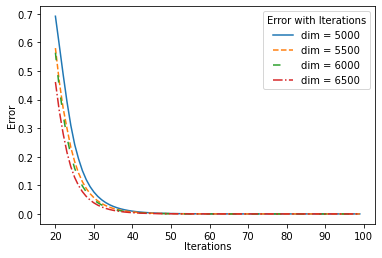

In [387]:
plt.figure()
plt.title("", pad = 14, loc = "center")
plt.plot(range(20,100), np.array(dim_err[0])[20:],  label= "dim = 5000", linestyle='-')
plt.plot(range(20,100), np.array(dim_err[1])[20:], label= "dim = 5500", linestyle='--')
plt.plot(range(20,100), np.array(dim_err[2])[20:], label= "dim = 6000", linestyle =  (0, (5, 10)))
plt.plot(range(20,100), np.array(dim_err[3])[20:], label= "dim = 6500", linestyle='-.')
plt.legend(title="Error with Iterations")
plt.xlabel(xlabel="Iterations",labelpad = 0)
plt.ylabel(ylabel="Error",labelpad = 0)
plt.savefig('Fig_2_Khatri_Rao.png', dpi=300,  bbox_inches="tight")

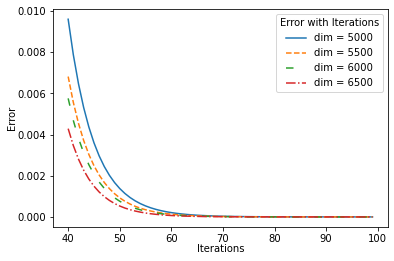

In [386]:
plt.figure()
plt.title("", pad = 14, loc = "center")
plt.plot(range(40,100), np.array(dim_err[0])[40:],  label= "dim = 5000", linestyle='-')
plt.plot(range(40,100), np.array(dim_err[1])[40:], label= "dim = 5500", linestyle='--')
plt.plot(range(40,100), np.array(dim_err[2])[40:], label= "dim = 6000", linestyle =  (0, (5, 10)))
plt.plot(range(40,100), np.array(dim_err[3])[40:], label= "dim = 6500", linestyle='-.')
plt.legend(title="Error with Iterations")
plt.xlabel(xlabel="Iterations",labelpad = 0)
plt.ylabel(ylabel="Error",labelpad = 0)
plt.savefig('Fig_1_Khatri_Rao.png', dpi=300,  bbox_inches="tight")

In [418]:
## Sparse Johnson Lindenstrauss Transformations

def SJLT(dim, n , s):    ##Based on rademacher
    delta = np.zeros((s,n))
    matrix = np.zeros((dim,n))
    sigma = np.zeros((dim,n))
    
    for i in range(s): 
        for j in range(n): 
            delta[i, j] = np.random.randint(2) * 2 - 1
    
    #ones = np.zeros(s)+1
    for i in range(n):
        sparse_col = np.random.choice(dim, s, replace=False)
        #sigma[sparse_col,i] = ones
        matrix[sparse_col,i] = delta[:,i]
        
    return np.sqrt(1/s)*matrix


## Sparsifying Random Gaussian Matrices

def sparse_gaussian(dim, n , s):      ##Based on Random Gaussian
    delta = np.random.normal(0.0,1.0,(s,n))
    matrix = np.zeros((dim,n))
    sigma = np.zeros((dim,n))

    
    #ones = np.zeros(s)+1
    for i in range(n):
        sparse_col = np.random.choice(dim, s, replace=False)
        #sigma[sparse_col,i] = ones
        matrix[sparse_col,i] = delta[:,i]
        
    return np.sqrt(1/s)*matrix



In [422]:
##Sparse Johnson Lindenstrauss - Rademacher based

n = (20,20,20) ### Mode 3 rank 2 tensors
n_prod = 20*20*20
dim = 6500
s = 5500

X = random_low_cp_rank(n,2)
X_ravel = np.ravel(X)
X_ravel = X_ravel/np.linalg.norm(X_ravel)

## Generating SJLT Random Projection Matrix

AA = SJLT(dim,n_prod,s)

In [423]:
## Checking if this is a reasonable Random Projection

np.abs(np.linalg.norm(AA@X_ravel)-1)

0.004747077847064851

In [424]:
vXX = torch.randn(n)
print(np.linalg.norm(vectorize(vXX)- X_ravel))
yy = np.matmul(AA, np.array(vectorize(X_ravel)))
Diff = np.linalg.norm(vectorize(vXX)- X_ravel)/np.linalg.norm(X_ravel)
print(Diff)

90.09264570564216
90.09264570564216


In [425]:
j = 0
num_its = 1000

while j < num_its and Diff > 0.001:
    WW = np.array(vectorize(vXX)) + 0.3 * np.matmul(AA.T, (yy - np.matmul(AA, np.array(vectorize(vXX)))))
    WW = torch.reshape(torch.tensor(WW), n)
    vXX = low_rank_approx(WW,3)
    Diff = np.linalg.norm(vectorize(vXX)- X_ravel)
    #print(Diff)
    j = j + 1
    
print("Converges in:", j, " iterations with error: ", Diff )

Converges in: 36  iterations with error:  0.0009314938090098009


In [447]:
## TIHT Convergence; Rank r = 3, Changing Dimension keeping sparsity percentage constant at 0.8

n = (20,20,20) ### Mode 3 rank 3 tensors
dim = [4000,5000,6000,7000]
s = [3200,4000,4800,5600]
s_err = []

for r in range(len(s)):
    AA = SJLT(dim[r],n_prod,s[r])
    num_samples = 50

    err = []

    for k in range(num_samples):
        print(k)
        X = random_low_cp_rank(n,3)
        X_ravel = np.ravel(X)
        X_ravel = X_ravel/np.linalg.norm(X_ravel)
        err_k = []
    
        vXX = torch.randn(n)
        yy = np.matmul(AA, np.array(vectorize(X_ravel)))
        Diff = np.linalg.norm(vectorize(vXX)- X_ravel)/np.linalg.norm(X_ravel)
        j = 0
    
        while j < 100:
            WW = np.array(vectorize(vXX)) + 0.3 * np.matmul(AA.T, (yy - np.matmul(AA, np.array(vectorize(vXX)))))
            WW = torch.reshape(torch.tensor(WW), n)
            vXX = low_rank_approx(WW,3)
            Diff = np.linalg.norm(vectorize(vXX)- X_ravel)
            err_k = err_k + [Diff]
            j = j+1  
        err = err + [err_k]
    
    err = np.array(err)
    avg = np.mean(err, axis = 0)

    s_err = s_err + [avg]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


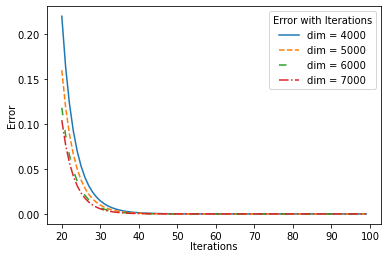

In [449]:
plt.figure()
plt.title("", pad = 14, loc = "center")
plt.plot(range(20,100), np.array(s_err[0])[20:],  label= "dim = 4000", linestyle='-')
plt.plot(range(20,100), np.array(s_err[1])[20:], label= "dim = 5000", linestyle='--')
plt.plot(range(20,100), np.array(s_err[2])[20:], label= "dim = 6000", linestyle =  (0, (5, 10)))
plt.plot(range(20,100), np.array(s_err[3])[20:], label= "dim = 7000", linestyle='-.')
plt.legend(title="Error with Iterations")
plt.xlabel(xlabel="Iterations",labelpad = 0)
plt.ylabel(ylabel="Error",labelpad = 0)
plt.savefig('Fig_4_SJLT.png', dpi=300,  bbox_inches="tight")

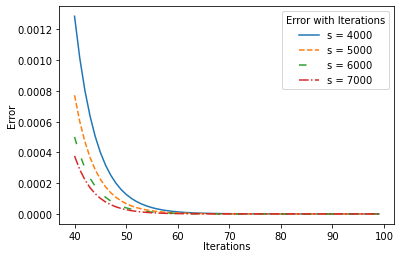

In [450]:
plt.figure()
plt.title("", pad = 14, loc = "center")
plt.plot(range(40,100), np.array(s_err[0])[40:],  label= "s = 4000", linestyle='-')
plt.plot(range(40,100), np.array(s_err[1])[40:], label= "s = 5000", linestyle='--')
plt.plot(range(40,100), np.array(s_err[2])[40:], label= "s = 6000", linestyle =  (0, (5, 10)))
plt.plot(range(40,100), np.array(s_err[3])[40:], label= "s = 7000", linestyle='-.')
plt.legend(title="Error with Iterations")
plt.xlabel(xlabel="Iterations",labelpad = 0)
plt.ylabel(ylabel="Error",labelpad = 0)
plt.savefig('Fig_5_SJLT.png', dpi=300,  bbox_inches="tight")

In [427]:
## TIHT Convergence; Rank r = 3, Fixed Dimension Changing Sparsity

n = (20,20,20) ### Mode 3 rank 3 tensors
dim = 6000
s = [4000,4500,5000,5500]
s_err = []

for r in range(len(s)):
    AA = SJLT(dim,n_prod,s[r])
    num_samples = 50

    err = []

    for k in range(num_samples):
        X = random_low_cp_rank(n,3)
        X_ravel = np.ravel(X)
        X_ravel = X_ravel/np.linalg.norm(X_ravel)
        err_k = []
    
        vXX = torch.randn(n)
        yy = np.matmul(AA, np.array(vectorize(X_ravel)))
        Diff = np.linalg.norm(vectorize(vXX)- X_ravel)/np.linalg.norm(X_ravel)
        j = 0
    
        while j < 100:
            WW = np.array(vectorize(vXX)) + 0.3 * np.matmul(AA.T, (yy - np.matmul(AA, np.array(vectorize(vXX)))))
            WW = torch.reshape(torch.tensor(WW), n)
            vXX = low_rank_approx(WW,3)
            Diff = np.linalg.norm(vectorize(vXX)- X_ravel)
            err_k = err_k + [Diff]
            j = j+1  
        err = err + [err_k]
    
    err = np.array(err)
    avg = np.mean(err, axis = 0)

    s_err = s_err + [avg]

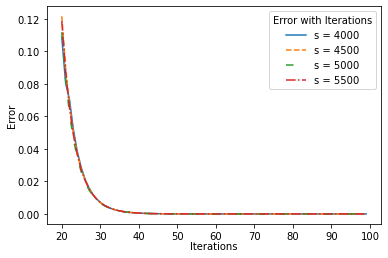

In [428]:
plt.figure()
plt.title("", pad = 14, loc = "center")
plt.plot(range(20,100), np.array(s_err[0])[20:],  label= "s = 4000", linestyle='-')
plt.plot(range(20,100), np.array(s_err[1])[20:], label= "s = 4500", linestyle='--')
plt.plot(range(20,100), np.array(s_err[2])[20:], label= "s = 5000", linestyle =  (0, (5, 10)))
plt.plot(range(20,100), np.array(s_err[3])[20:], label= "s = 5500", linestyle='-.')
plt.legend(title="Error with Iterations")
plt.xlabel(xlabel="Iterations",labelpad = 0)
plt.ylabel(ylabel="Error",labelpad = 0)
plt.savefig('Fig_1_SJLT.png', dpi=300,  bbox_inches="tight")

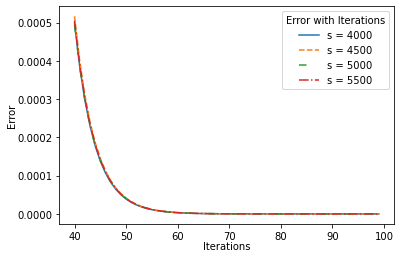

In [429]:
plt.figure()
plt.title("", pad = 14, loc = "center")
plt.plot(range(40,100), np.array(s_err[0])[40:],  label= "s = 4000", linestyle='-')
plt.plot(range(40,100), np.array(s_err[1])[40:], label= "s = 4500", linestyle='--')
plt.plot(range(40,100), np.array(s_err[2])[40:], label= "s = 5000", linestyle =  (0, (5, 10)))
plt.plot(range(40,100), np.array(s_err[3])[40:], label= "s = 5500", linestyle='-.')
plt.legend(title="Error with Iterations")
plt.xlabel(xlabel="Iterations",labelpad = 0)
plt.ylabel(ylabel="Error",labelpad = 0)
plt.savefig('Fig_2_SJLT.png', dpi=300,  bbox_inches="tight")

In [430]:
##Sparse Johnson Lindenstrauss - Gaussian based

n = (20,20,20) ### Mode 3 rank 2 tensors
n_prod = 20*20*20
dim = 6500
s = 5500

X = random_low_cp_rank(n,2)
X_ravel = np.ravel(X)
X_ravel = X_ravel/np.linalg.norm(X_ravel)

## Generating Sparse Gaussian Random Projection Matrix

AA = sparse_gaussian(dim,n_prod,s)

In [431]:
## Checking if this is a reasonable Random Projection

np.abs(np.linalg.norm(AA@X_ravel)-1)

0.014330233168389439

In [432]:
vXX = torch.randn(n)
print(np.linalg.norm(vectorize(vXX)- X_ravel))
yy = np.matmul(AA, np.array(vectorize(X_ravel)))
Diff = np.linalg.norm(vectorize(vXX)- X_ravel)/np.linalg.norm(X_ravel)
print(Diff)

89.97060170158811
89.97060170158811


In [433]:
j = 0
num_its = 1000

while j < num_its and Diff > 0.001:
    WW = np.array(vectorize(vXX)) + 0.3 * np.matmul(AA.T, (yy - np.matmul(AA, np.array(vectorize(vXX)))))
    WW = torch.reshape(torch.tensor(WW), n)
    vXX = low_rank_approx(WW,3)
    Diff = np.linalg.norm(vectorize(vXX)- X_ravel)
    #print(Diff)
    j = j + 1
    
print("Converges in:", j, " iterations with error: ", Diff )

Converges in: 37  iterations with error:  0.0009325367872819166


In [451]:
## TIHT Convergence; Rank r = 3, Changing Dimension keeping sparsity percentage constant at 0.8

n = (20,20,20) ### Mode 3 rank 3 tensors
dim = [4000,5000,6000,7000]
s = [3200,4000,4800,5600]
s_err = []

for r in range(len(s)):
    AA = sparse_gaussian(dim[r],n_prod,s[r])
    num_samples = 50

    err = []

    for k in range(num_samples):
        print(k)
        X = random_low_cp_rank(n,3)
        X_ravel = np.ravel(X)
        X_ravel = X_ravel/np.linalg.norm(X_ravel)
        err_k = []
    
        vXX = torch.randn(n)
        yy = np.matmul(AA, np.array(vectorize(X_ravel)))
        Diff = np.linalg.norm(vectorize(vXX)- X_ravel)/np.linalg.norm(X_ravel)
        j = 0
    
        while j < 100:
            WW = np.array(vectorize(vXX)) + 0.3 * np.matmul(AA.T, (yy - np.matmul(AA, np.array(vectorize(vXX)))))
            WW = torch.reshape(torch.tensor(WW), n)
            vXX = low_rank_approx(WW,3)
            Diff = np.linalg.norm(vectorize(vXX)- X_ravel)
            err_k = err_k + [Diff]
            j = j+1  
        err = err + [err_k]
    
    err = np.array(err)
    avg = np.mean(err, axis = 0)

    s_err = s_err + [avg]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


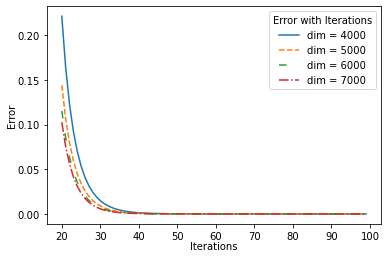

In [452]:
plt.figure()
plt.title("", pad = 14, loc = "center")
plt.plot(range(20,100), np.array(s_err[0])[20:],  label= "dim = 4000", linestyle='-')
plt.plot(range(20,100), np.array(s_err[1])[20:], label= "dim = 5000", linestyle='--')
plt.plot(range(20,100), np.array(s_err[2])[20:], label= "dim = 6000", linestyle =  (0, (5, 10)))
plt.plot(range(20,100), np.array(s_err[3])[20:], label= "dim = 7000", linestyle='-.')
plt.legend(title="Error with Iterations")
plt.xlabel(xlabel="Iterations",labelpad = 0)
plt.ylabel(ylabel="Error",labelpad = 0)
plt.savefig('Fig_4_Sparse_gauss.png', dpi=300,  bbox_inches="tight")

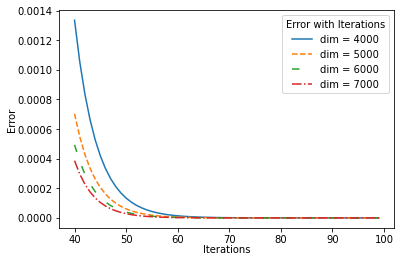

In [453]:
plt.figure()
plt.title("", pad = 14, loc = "center")
plt.plot(range(40,100), np.array(s_err[0])[40:],  label= "dim = 4000", linestyle='-')
plt.plot(range(40,100), np.array(s_err[1])[40:], label= "dim = 5000", linestyle='--')
plt.plot(range(40,100), np.array(s_err[2])[40:], label= "dim = 6000", linestyle =  (0, (5, 10)))
plt.plot(range(40,100), np.array(s_err[3])[40:], label= "dim = 7000", linestyle='-.')
plt.legend(title="Error with Iterations")
plt.xlabel(xlabel="Iterations",labelpad = 0)
plt.ylabel(ylabel="Error",labelpad = 0)
plt.savefig('Fig_5_Sparse_gauss.png', dpi=300,  bbox_inches="tight")

In [439]:
## TIHT Convergence; Rank r = 3, Fixed Dimension Changing Sparsity

n = (20,20,20) ### Mode 3 rank 3 tensors
dim = 6000
s = [4000,4500,5000,5500]
s_err = []

for r in range(len(s)):
    AA = sparse_gaussian(dim,n_prod,s[r])
    num_samples = 50

    err = []

    for k in range(num_samples):
        X = random_low_cp_rank(n,3)
        X_ravel = np.ravel(X)
        X_ravel = X_ravel/np.linalg.norm(X_ravel)
        err_k = []
    
        vXX = torch.randn(n)
        yy = np.matmul(AA, np.array(vectorize(X_ravel)))
        Diff = np.linalg.norm(vectorize(vXX)- X_ravel)/np.linalg.norm(X_ravel)
        j = 0
    
        while j < 100:
            WW = np.array(vectorize(vXX)) + 0.3 * np.matmul(AA.T, (yy - np.matmul(AA, np.array(vectorize(vXX)))))
            WW = torch.reshape(torch.tensor(WW), n)
            vXX = low_rank_approx(WW,3)
            Diff = np.linalg.norm(vectorize(vXX)- X_ravel)
            err_k = err_k + [Diff]
            j = j+1  
        err = err + [err_k]
    
    err = np.array(err)
    avg = np.mean(err, axis = 0)

    s_err = s_err + [avg]

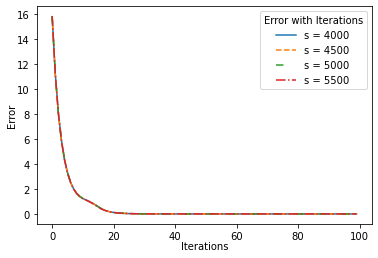

In [438]:
plt.figure()
plt.title("", pad = 14, loc = "center")
plt.plot(range(100), np.array(s_err[0])[:],  label= "s = 4000", linestyle='-')
plt.plot(range(100), np.array(s_err[1])[:], label= "s = 4500", linestyle='--')
plt.plot(range(100), np.array(s_err[2])[:], label= "s = 5000", linestyle =  (0, (5, 10)))
plt.plot(range(100), np.array(s_err[3])[:], label= "s = 5500", linestyle='-.')
plt.legend(title="Error with Iterations")
plt.xlabel(xlabel="Iterations",labelpad = 0)
plt.ylabel(ylabel="Error",labelpad = 0)
plt.savefig('Fig_3_Sparse_Gaussian.png', dpi=300,  bbox_inches="tight")

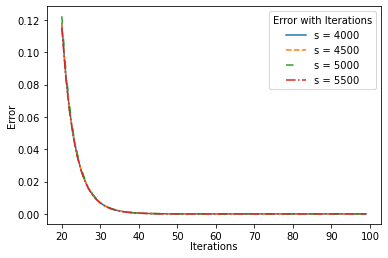

In [436]:
plt.figure()
plt.title("", pad = 14, loc = "center")
plt.plot(range(20,100), np.array(s_err[0])[20:],  label= "s = 4000", linestyle='-')
plt.plot(range(20,100), np.array(s_err[1])[20:], label= "s = 4500", linestyle='--')
plt.plot(range(20,100), np.array(s_err[2])[20:], label= "s = 5000", linestyle =  (0, (5, 10)))
plt.plot(range(20,100), np.array(s_err[3])[20:], label= "s = 5500", linestyle='-.')
plt.legend(title="Error with Iterations")
plt.xlabel(xlabel="Iterations",labelpad = 0)
plt.ylabel(ylabel="Error",labelpad = 0)
plt.savefig('Fig_1_Sparse_Gaussian.png', dpi=300,  bbox_inches="tight")

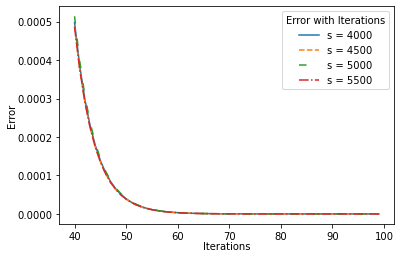

In [437]:
plt.figure()
plt.title("", pad = 14, loc = "center")
plt.plot(range(40,100), np.array(s_err[0])[40:],  label= "s = 4000", linestyle='-')
plt.plot(range(40,100), np.array(s_err[1])[40:], label= "s = 4500", linestyle='--')
plt.plot(range(40,100), np.array(s_err[2])[40:], label= "s = 5000", linestyle =  (0, (5, 10)))
plt.plot(range(40,100), np.array(s_err[3])[40:], label= "s = 5500", linestyle='-.')
plt.legend(title="Error with Iterations")
plt.xlabel(xlabel="Iterations",labelpad = 0)
plt.ylabel(ylabel="Error",labelpad = 0)
plt.savefig('Fig_2_Sparse_Gaussian.png', dpi=300,  bbox_inches="tight")

In [455]:
### Database Friendly Measurements 
## Fast Johnson Lindenstrauss Transform



In [456]:
### Database Friendly Measurements 
## Kronecker Fast Johnson Lindenstrauss Transform

In [105]:
## Modewise without reshaping 

n = [19,19,19]
target = [16,16,16] ### Mode 3 rank 3 tensors

X = random_low_cp_rank(n,2)
XX = tl.tensor(X)
X_ravel = np.ravel(X)
X_ravel = X_ravel/np.linalg.norm(X_ravel)
XX = tl.tensor(X_ravel)

## Generating Modewise Measurement operators

AA_1 = np.random.normal(0.0,1.0,(target[0],n[0]))
AA_2 = np.random.normal(0.0,1.0,(target[1],n[1]))
AA_3 = np.random.normal(0.0,1.0,(target[2],n[2]))

AA = np.sqrt(1/(16*16*16))*np.kron(np.kron(AA_1,AA_2),AA_3)
yy = AA@X_ravel

In [106]:
np.linalg.norm(yy)

0.9342154597629936

In [107]:
vXX = torch.randn(n)
#print(np.linalg.norm(vectorize(vXX)- X_ravel))
Diff = np.linalg.norm(vectorize(vXX)- X_ravel)/np.linalg.norm(X_ravel)
print(Diff)

83.42251712402174


In [108]:
## Understanding the importance of momenetum or step size???

j = 1
num_its = 8000
Diff_1 = []

while j < num_its and Diff > 0.001:
    WW = np.array(vectorize(vXX)) + 0.1 * np.matmul(AA.T, (yy - np.matmul(AA, np.array(vectorize(vXX)))))
    WW = torch.reshape(torch.tensor(WW), n)
    vXX = low_rank_approx(WW,2)
    Diff = np.linalg.norm(vectorize(vXX)- X_ravel)
    if j%100 == 0:
        print("Error after ",j, " iterations: ", Diff )
    j = j + 1
    

Error after  0  iterations:  16.189678864290435
Error after  100  iterations:  12.05197193856159
Error after  200  iterations:  11.51665831300729
Error after  300  iterations:  11.227858259480557
Error after  400  iterations:  11.03560134274556
Error after  500  iterations:  10.893872423629782
Error after  600  iterations:  10.782831940329077
Error after  700  iterations:  9.009611782422725
Error after  800  iterations:  8.947285500020685
Error after  900  iterations:  8.89364206128305
Error after  1000  iterations:  8.84659183337443
Error after  1100  iterations:  8.8048009401739
Error after  1200  iterations:  8.767462456973405
Error after  1300  iterations:  8.734354831302616
Error after  1400  iterations:  8.706590793772518
Error after  1500  iterations:  8.689818944396997
Error after  1600  iterations:  8.687106768082051
Error after  1700  iterations:  8.658213466953239
Error after  1800  iterations:  8.612999851983838
Error after  1900  iterations:  8.565671585279748
Error after 

In [18]:
## Checking modewise measurements: Sanity Check

X = random_low_cp_rank([4,4,4],3)
XX = np.ravel(X)
n_prod = 64

AA_1 = np.random.normal(0.0,1.0,(3,4))
AA_2 = np.random.normal(0.0,1.0,(3,4))
AA_3 = np.random.normal(0.0,1.0,(3,4))

AA = np.kron(np.kron(AA_1,AA_2),AA_3)
np.reshape(AA@XX,[3,3,3])

AA@X

tl.tenalg.mode_dot(tl.tenalg.mode_dot(tl.tenalg.mode_dot(tl.tensor(X),AA_1,0),AA_2,1),AA_3,2)